In [26]:
from models.gan_model import *
from models.networks import *
import torch
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.datasets import TUDataset
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.data import Data, Batch
import networkx as nx
from torch_geometric.nn import GCNConv

In [27]:
root = './enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset = TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

ENZYMES(600)


In [28]:
def fix_size_adj(graph):
    input_tensor = to_dense_adj(graph.edge_index)[0]
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(input_tensor.shape[1], 42 - input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros], dim=1)

        zeros = torch.zeros(42 - input_tensor.shape[1], 42)
        tensor = torch.cat([tensor, zeros], dim=0)
        return tensor
    else:
        return input_tensor
    
    
def fix_size_feat(graph):
    input_tensor = graph.x
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(42 - input_tensor.shape[0], input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros])
        return tensor
    else:
        return input_tensor

In [29]:
graphs_relevance = [g for g in pyg_dataset if g.num_nodes in [38, 40, 42]]
graphs = torch.zeros(71, 42, 42)
features = torch.zeros(71, 42, 3)
for i in range(len(graphs_relevance)):
    graphs[i] = fix_size_adj(graphs_relevance[i])
    features[i] = fix_size_feat(graphs_relevance[i])

In [30]:
batch_size = 8
z_size = 100
graphs_dataset = TensorDataset(features, graphs)
graphs_dataloader = DataLoader(graphs_dataset, batch_size)

features_dataset = TensorDataset(features)
features_dataloader = DataLoader(features_dataset, batch_size)

In [31]:
feature_gan = GraphGAN(num_vertex=42, lr=1e-4, generator=FeatureGenerator(z_size, 42, 3), discriminator=FeatureDiscriminator(42, 3))

In [32]:
def train(model, dataloader, num_epochs=10, print_every=1):
    for epoch in range(num_epochs):
        g_l = 0
        d_l = 0
        for batch in dataloader:
            data = batch
            image_size = data[0].size(0)

            gl, dl = model.forward(data, image_size)
            g_l += gl
            d_l += dl
        if (epoch + 1) % print_every == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(num_epochs)
                  + "\td_loss:" + str(round(d_l / len(dataloader), 4))
                  + "\tg_loss:" + str(round(g_l / len(dataloader), 4))
                  )

In [33]:
train(feature_gan, graphs_dataloader, num_epochs=200, print_every=10)

Epoch: 10/200	d_loss:1.3207	g_loss:0.8104
Epoch: 20/200	d_loss:1.421	g_loss:0.7275
Epoch: 30/200	d_loss:1.4145	g_loss:0.6865
Epoch: 40/200	d_loss:1.3632	g_loss:0.6808
Epoch: 50/200	d_loss:1.3377	g_loss:0.6554
Epoch: 60/200	d_loss:1.4603	g_loss:0.5847
Epoch: 70/200	d_loss:1.345	g_loss:0.8449
Epoch: 80/200	d_loss:1.4147	g_loss:0.692
Epoch: 90/200	d_loss:1.3478	g_loss:0.6864
Epoch: 100/200	d_loss:1.2948	g_loss:0.6762
Epoch: 110/200	d_loss:1.4024	g_loss:0.5873
Epoch: 120/200	d_loss:1.2981	g_loss:0.755
Epoch: 130/200	d_loss:1.2625	g_loss:0.8551
Epoch: 140/200	d_loss:1.3577	g_loss:0.6978
Epoch: 150/200	d_loss:1.3833	g_loss:0.6106
Epoch: 160/200	d_loss:1.337	g_loss:0.6647
Epoch: 170/200	d_loss:1.2865	g_loss:0.7268
Epoch: 180/200	d_loss:1.2349	g_loss:0.7821
Epoch: 190/200	d_loss:1.256	g_loss:0.7329
Epoch: 200/200	d_loss:1.3384	g_loss:0.604


In [34]:
_, graph_output = feature_gan.generate_adj(return_symmetric=False)
graph_output = graph_output.squeeze().detach().numpy()

In [35]:
G = nx.from_numpy_array(graph_output, create_using=nx.Graph())

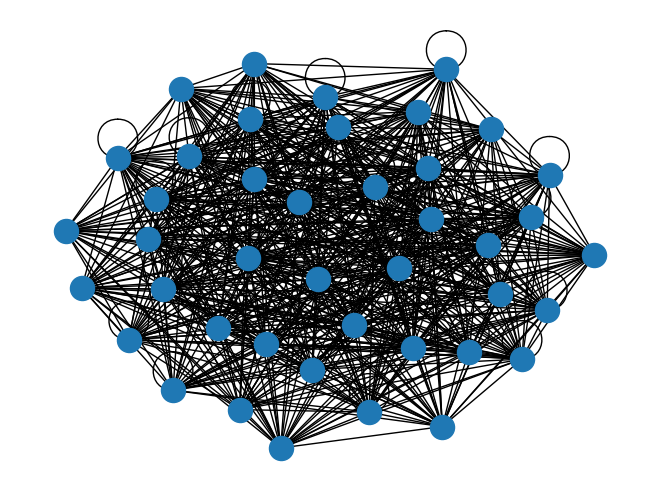

In [36]:
nx.draw(G)